# 02.Convolution Neural Network
---
流程圖  
![](https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/images/02_network_flowchart.png)

## Import Library
---

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

import time
from datetime import timedelta
import math

## 讀測試資料
---

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("/data/MNIST", one_hot = True)

Extracting /data/MNIST\train-images-idx3-ubyte.gz
Extracting /data/MNIST\train-labels-idx1-ubyte.gz
Extracting /data/MNIST\t10k-images-idx3-ubyte.gz
Extracting /data/MNIST\t10k-labels-idx1-ubyte.gz


## 設定 Convolution Neural Network
---

In [3]:
# Layer 1
filter_size1 = 5                    # 5 x 5 的 Filter
num_filters1 = 16

# Layer 2
filter_size2 = 5
num_filters2 = 36

# Fully Connected Layer
full_connected_layer_size = 128

## 資料的維度
---
底下的變數是 MNIST 的資料維度

In [4]:
img_size = 28                                                       # 長
img_size_flat = img_size * img_size                                 # 平面轉成 1D 的資料大小
img_shape = (img_size, img_size)                                    # 整個陣列的維度
num_classes = 10                                                    # 總共有幾個 Class (0 ~ 10)
num_channels = 1                                                    # 資料維度 => 因為是灰階，所以是 1

## 跟圖相關的 Helper Functions
---
顯示圖片

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9                        # 設定只顯示九張圖
    
    fig, axes = plt.subplots(3, 3)                                  # 產生一章圖，只有 3 x 3
    fig.subplots_adjust(hspace=0.3, wspace=0.3)                     # 產生間隔

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')      # 將圖片 imshow 出來

        if cls_pred is None:                                        # 假設沒有預測的值時，只顯示 True 的 Label
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        
        # 刪除坐標軸
        ax.set_xticks([])
        ax.set_yticks([])

In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [7]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

## 先設定輸入相關的變數(Place Holder)
---
在 ConvNet 中  
是假設輸入的形式是四個維度的資料：  
1. Image Number
2. Y axis
3. X axis
4. channel

輸出的部分：  
1. Image Number
2. Y axis, 但如果有使用 max pooling(2x2) 的話，那會是除以 2 
3. X axis, 同上
4. 在經過 Convoultional 的時候，會經過非常多的 Filter，所以這個 Channel 是用來表示 Filter 後的結果

所以當資料 X 輸入的時候  
需要轉乘 x_image 也就是上面說的四個維度  
才能做輸出的部分  
而因為 第一個參數 Image 數目  
不會用到所以給 -1

In [8]:
x = tf.placeholder(tf.float32, [None, img_size_flat], name="x")
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, [None, num_classes], name="labels")
y_ground_truth = tf.argmax(y_true, 1)

## 產生第一層
---
第一層是使用
ConvNet + Pooling

### ConvNet 的重要參數
tf.layers.conv2d(  
    inputs,                  => 輸入圖片  
    filters,                 => Filter 數目EX  
    kernel_size,             => Filter 大小  
    strides,                 => 使用 Filter 的時候，每次位移多少  
    padding,                 => 當Filter移到不夠格子時，補充的方式(如下圖，只有兩種方式)，大小寫無關  
    activation               => Output的資料，要不要做 Normalize  
)
![範例圖](https://i.imgur.com/dJd6mIr.png) 
### Pooling Layer 的重要參數
tf.layers.max_pooling2d(  
    inputs,                  => 輸入圖片  
    pool_size,               => Pool 大小  
    strides,                 => 使用 Filter 的時候，每次位移多少  
)

In [9]:
with tf.name_scope("ConvNet_1"):
    layer_conv1 = tf.layers.conv2d(
        inputs=x_image,
        filters=num_filters1,
        kernel_size=filter_size1,
        strides=1,
        padding="SAME",
        activation=tf.nn.relu
    )
    layer1 = tf.layers.max_pooling2d(
        layer_conv1,
        pool_size=2,
        strides=2
    )
    print(layer1)

Tensor("ConvNet_1/max_pooling2d/MaxPool:0", shape=(?, 14, 14, 16), dtype=float32)


### 產生第二層
---
同樣是 ConvNet + Pooling  
只是這層的 Filter 的 Size 比較大

In [10]:
with tf.name_scope("ConvNet_2"):
    layer_conv2 = tf.layers.conv2d(
        layer1,
        num_filters2,
        filter_size2,
        1,
        "same",
        activation = tf.nn.relu
    )
    layer2 = tf.layers.max_pooling2d(
        layer_conv2,
        pool_size=2,
        strides=2
    )
    print(layer2)

Tensor("ConvNet_2/max_pooling2d/MaxPool:0", shape=(?, 7, 7, 36), dtype=float32)


## Fully-Connected Layer
---
剛剛好 Tensorflow 有一個函式  
叫做 tf.layers.dense(  
inputs,                       => 輸入
units                         => 輸出的個數
)  
而 dense 的 inputs 必須要要是 2 維的陣列  
所以要先經過 resshape  

In [11]:
with tf.name_scope("Fully-Connected_128"):
    flat = tf.reshape(layer2, [-1, 7 * 7 * 36])
    output1 = tf.layers.dense(
        inputs=flat,
        units=full_connected_layer_size,
    )
    output1_lu = tf.nn.relu(output1)
with tf.name_scope("Output_10"):
    output = tf.layers.dense(
        inputs=output1_lu,
        units=num_classes
    )
    print(output)

Tensor("Output_10/dense/BiasAdd:0", shape=(?, 10), dtype=float32)


## 將預測轉乘數字
---

In [12]:
y_pred = tf.nn.softmax(output)           # 將所有的數字轉乘 0 ~ 1 的機率
y_pred_value= tf.argmax(y_pred, axis=1)  # 取出最大的 Index

## 使用 Cross-Entropy 來產生要 Optimized 的 Cost-function
---
因為 Cross-Entropy 比較快  
比 Sigmoid 快  

因為每個 class 都有一點點 error  
阿每個 Error 取平均  
加起來  

### tf.losses.softmax_cross_entropy
根據[官方文件](https://www.tensorflow.org/api_docs/python/tf/losses/softmax_cross_entropy)說明了  
如果 reduction 是 NONE 的話  
那這樣 return 的會是大小為 10 的陣列  
可是如果沒有給特定值得話  
回傳會經過 mean 之後再回傳

In [13]:
with tf.name_scope("CrossEntropy"):
    cost = tf.losses.softmax_cross_entropy(
        logits=output, 
        onehot_labels=y_true
    )
    
# 加進 Summary 裡
tf.summary.scalar("Cost", cost)

<tf.Tensor 'Cost:0' shape=() dtype=string>

## Optimized 的方法
---

In [14]:
with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance 
---
correct_prediction 是把所有的陣列，拿下來做比較  
所以回得到相同陣列長度的 boolean  
EX:  
\[True, False, False, True ....\]  


接者須要把全部的 Boolean 經由 False = 0, True = 1  
轉乘 tf.float32 的陣列  
在全部加起來取平均

In [15]:
with tf.name_scope("Accuracy"):
    correct_prediction = tf.equal(y_pred_value, y_ground_truth)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
# 加進 Summary 裡
tf.summary.scalar("Accuary", accuracy)

<tf.Tensor 'Accuary:0' shape=() dtype=string>

## Tensorflow Run
---

In [16]:
session = tf.Session();
session.run(tf.global_variables_initializer())

## Helper-Function
---
**注意!!**  
此地方可能會有 RAM 爆掉的問題  
如果會報掉  
請減少 train_batch_size  
並增加 Iteration 的數目

In [17]:
train_batch_size = 64

In [18]:
# 要確認總共做了幾個 Iteration
total_iteration = 0

def optimize(num_iterations):
    # 確保拿的是 Global 的變數
    global total_iteration
    
    # 開始時間
    start_time = time.time()
    
    for i in range(total_iteration, total_iteration + num_iterations):
        # 拿 Batch 資料為進去
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        # 預測
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        # 跑預測，及最佳會 NN
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            # 準確度
            acc = session.run(accuracy, feed_dict_train)
            
            # 訊息
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            print(msg.format(i+1, acc))
            
            # 因為這時候還不知道結果，所以要把全部之前跑過的都拿進來
            logs = tf.summary.FileWriter("./logs")
            merge = tf.summary.merge_all()
            s = session.run(merge, feed_dict= feed_dict_train)
            logs.add_summary(s, i)
            
    # 增加 Total Iteration
    total_iteration += num_iterations
    
    # 結束時間
    end_time = time.time()
    
    # 算時間差
    time_diff = end_time - start_time
    
    # 使用時間
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

## Helper Function 來畫出錯誤
---
Plot 前九個 Error

In [19]:
def plot_example_errors(cls_pred, correct):
    # 將陣列裡面的值，做反向
    incorrect = (correct == False)
    
    #拿出所有為 True 的圖
    images = data.test.images[incorrect]
    
    # 拿判斷結果
    cls_pred = cls_pred[incorrect]

    # 拿出正確的解答
    cls_true = data.test.cls[incorrect]
    
    # 顯示前九張圖
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [20]:
# 每次拿一小部分
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = session.run(y_pred_value, feed_dict=feed_dict)
        i = j

    cls_true = data.test.cls

    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Tensor Graph
---
要 Call 的話  
要使用 tf.summary.FileWriter()
再把 資料 addGraph進去

In [21]:
# 寫到 Tensorboard
log = tf.summary.FileWriter("./logs")
log.add_graph(session.graph)  

## 沒做優化前
---

In [22]:
print_test_accuracy()

Accuracy on Test-Set: 10.5% (1054 / 10000)


# 優化 1 次
---

In [23]:
optimize(1)

Optimization Iteration:      1, Training Accuracy:  12.5%
Time usage: 0:00:00


Accuracy on Test-Set: 13.7% (1366 / 10000)
Example errors:


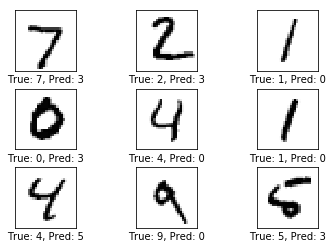

In [24]:
print_test_accuracy(show_example_errors=True)

## 優化 100 次
---

In [25]:
optimize(99)

Time usage: 0:00:01


Accuracy on Test-Set: 80.1% (8009 / 10000)
Example errors:


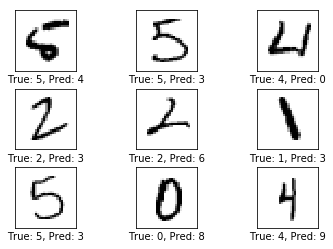

In [26]:
print_test_accuracy(show_example_errors=True)

## 優化 1000 次
---

In [27]:
optimize(900)

Optimization Iteration:    101, Training Accuracy:  70.3%
Optimization Iteration:    201, Training Accuracy:  92.2%
Optimization Iteration:    301, Training Accuracy:  95.3%
Optimization Iteration:    401, Training Accuracy:  92.2%
Optimization Iteration:    501, Training Accuracy:  89.1%
Optimization Iteration:    601, Training Accuracy:  92.2%
Optimization Iteration:    701, Training Accuracy:  95.3%
Optimization Iteration:    801, Training Accuracy: 100.0%
Optimization Iteration:    901, Training Accuracy:  93.8%
Time usage: 0:00:06


Accuracy on Test-Set: 95.0% (9501 / 10000)
Example errors:


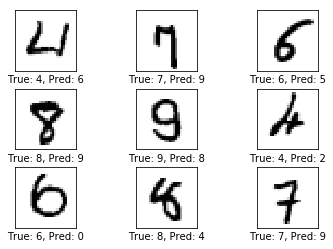

In [28]:
print_test_accuracy(show_example_errors=True)

## 優化 10,000 次
---

In [29]:
optimize(9000)

Optimization Iteration:   1001, Training Accuracy:  95.3%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy: 100.0%
Optimization Iteration:   1601, Training Accuracy: 100.0%
Optimization Iteration:   1701, Training Accuracy:  93.8%
Optimization Iteration:   1801, Training Accuracy:  95.3%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  95.3%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy:  95.3%
Optimization Iteration:   2501, Training Accuracy:  95.3%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.8% (9884 / 10000)
Example errors:
Confusion Matrix:
[[ 973    0    0    0    0    2    1    0    3    1]
 [   0 1127    1    0    0    1    1    1    4    0]
 [   0    1 1023    0    1    0    0    2    5    0]
 [   0    0    0 1004    0    2    0    2    2    0]
 [   0    0    2    0  978    0    0    0    0    2]
 [   1    0    0    2    0  888    1    0    0    0]
 [   6    2    0    0    2   10  934    0    4    0]
 [   1    2    6    1    0    0    0 1009    4    5]
 [   2    0    1    1    0    2    0    2  965    1]
 [   0    5    0    0    6    6    0    4    5  983]]


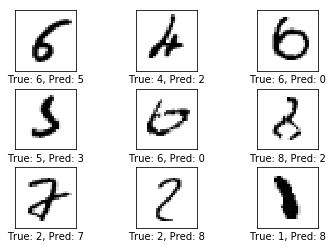

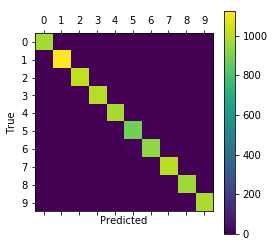

In [30]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [31]:
session.close()